# Machine Learning on TROPOMI Data

The notebook allows to generate the key figures from the paper.
It is provided for reproducibility purposes, allowing to have a closer look into the data and experiment design
The first part contains all the proxy-thresholds experiments and the second one generates the precision-recall curves

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, StratifiedGroupKFold, learning_curve, cross_val_score, GroupShuffleSplit
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, average_precision_score

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn import metrics
import itertools
from collections import Counter
from IPython.display import HTML
import os
import pickle
import glob
from pathlib import Path
import winsound
import logging

# import custom helper functions
import learn_tools

ROOT = '../../Data/'
DATASET_NAME= "5_hpo_reprise"
GASES = ['NO2', 'SO2', 'HCHO']
THREADS = -1
# hparams = {'subsample': 0.8999999999999999, 'reg_alpha': 0.01, 'n_estimators': 150, 'min_child_weight': 8, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.05}

SEARCH_SPACE = {
    'n_estimators': Integer(10, 500, name='n_estimators'),
    'gamma': Real(1e-8, 0.5, prior='log-uniform', name='gamma'),
    'max_depth': Integer(2, 10, name='max_depth'),
    'min_child_weight': Integer(1, 12, name='min_child_weight'),
    'subsample': Real(0.6, 1.0, prior='uniform', name='subsample'),
    'learning_rate': Real(1e-3, 1.0, prior='log-uniform', name='learning_rate'),
    'reg_alpha': Real(1e-8, 1.0, prior='log-uniform', name='reg_alpha')
}


# Proxy Distribution

ship_y
1    13858
0    11374
Name: count, dtype: int64


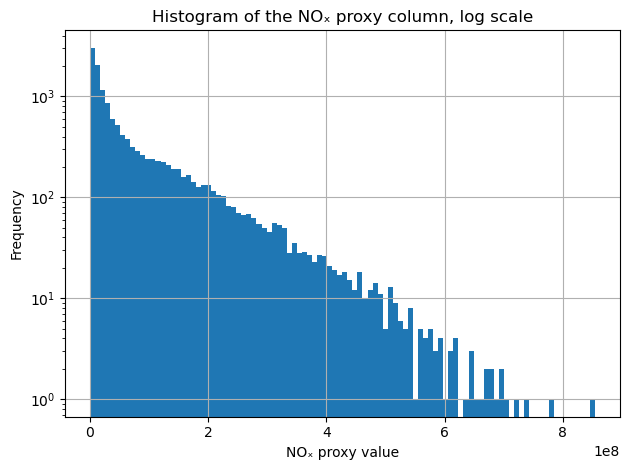

In [3]:
# DF_MED = pd.read_csv(ROOT+'AGG_DB/Mediterranean_False_186_0.1_50_4_max_0.005.csv')
DF_MED = pd.read_csv(ROOT+f'AGG_DB/{DATASET_NAME}.csv')
print(DF_MED['ship_y'].value_counts())
DF_MED.dropna(inplace=True)

# two columns figure
DF_MED[DF_MED['ship_y'] == 1]['Proxy'].hist(bins=100, log=True)
plt.title("Histogram of the NOₓ proxy column, log scale")
plt.xlabel("NOₓ proxy value")
plt.ylabel("Frequency")
plt.tight_layout()
os.makedirs(f"../../Figures/{DATASET_NAME}/", exist_ok=True)
plt.savefig(f"../../Figures/{DATASET_NAME}/Proxy_hist.pdf")
plt.show()

In [64]:
# print number of samples with proxy value between 4e8 and 6e8
print(DF_MED['Proxy'].between(3e8, 5e8).sum())

590


In [65]:
print(DF_MED[DF_MED['ship_y'] == 1]['Proxy'].describe())

count    1.380300e+04
mean     7.809378e+07
std      1.027086e+08
min      2.571934e+05
25%      1.015984e+07
50%      3.244461e+07
75%      1.106712e+08
max      8.539032e+08
Name: Proxy, dtype: float64


# Truncated Learning Curves

In [66]:
class LearningCurveAnalysis:
    def __init__(
            self, 
            dataset_name, 
            # Parameters for the learning curve
            window_size, 
            steps_train_size, 
            folds, 
            repeats, 
            tuning_steps, 
            window_centers,
            
            hpo=True, 
            overwrite=False,

                 ):
        self.dataset_name = dataset_name
        self.window_size = window_size
        self.steps_train_size = steps_train_size
        self.folds = folds
        self.repeats = repeats
        self.tuning_steps = tuning_steps
        self.hpo = hpo
        self.window_centers = window_centers
        self.directory = f"pkl/{self.dataset_name}/learning_curve_proxy/"
        self.combinations = [['NO2'], ['NO2', 'SO2', 'HCHO'], ['SO2'], ['HCHO']]
        self.overwrite = overwrite
        logging.info(f"Initialized LearningCurveAnalysis with HPO: {self.hpo}")

    def run(self):
        for combination in self.combinations:
            tqdm_window_iterator = tqdm(self.window_centers, desc="Windows", leave=True, postfix={"Combination": combination})
            for window in tqdm_window_iterator:
                # Generate the filename based on the current parameters
                parameters = {
                    "combination": '_'.join(combination),
                    "window_center": f"{window/1e8:.1f}e8",
                    "repeats": self.repeats,
                    "folds": self.folds,
                    "steps_train_size": self.steps_train_size,
                    "tuning_steps": self.tuning_steps,
                    "hpo": self.hpo
                }
                filename = learn_tools.generate_filename("learning_curve", parameters, directory=self.directory)

                if os.path.exists(filename) and not self.overwrite:
                    print(f"Results for {combination} and window {window} already exist. Skipping.")
                    continue

                datasets, train_indices, test_indices = self.create_splits(window)
                train_sizes_abs = self.get_train_sizes(train_indices)

                roc_auc_scores, avg_prec_scores = self.train_and_evaluate(
                    datasets, train_indices, test_indices, train_sizes_abs, combination
                )

                # Save results
                self.save_results(filename, train_sizes_abs, roc_auc_scores, avg_prec_scores)

                # write results to the progress bar
                tqdm_window_iterator.set_postfix({"ROC AUC": roc_auc_scores.mean(), "Avg. Prec.": avg_prec_scores.mean()})

    def get_data_for_window(self, window, seed):
        """
        Retrieves and prepares data for the given window.
        """
        one_data = DF_MED[DF_MED['Proxy'].between(window - self.window_size / 2, window + self.window_size / 2) & (DF_MED['Proxy'] != 0)]
        zero_data = DF_MED[DF_MED['Proxy'] == 0].sample(n=len(one_data), random_state=seed, replace=False)
        return one_data, zero_data

    def create_splits(self, window):
        """
        Create training and testing splits.
        """
        datasets, train_indices, test_indices = [], [], []
        for i in range(self.repeats):
            one_data, zero_data = self.get_data_for_window(window, i)
            data = pd.concat([one_data, zero_data])
            # shuffle data
            data = data.sample(frac=1, random_state=i).reset_index(drop=True)
            splitter = GroupShuffleSplit(n_splits=1, train_size=0.9, random_state=i)
            train_index, test_index = next(splitter.split(data, groups=data['date']))
            datasets.append(data)
            train_indices.append(train_index)
            test_indices.append(test_index)
        return datasets, train_indices, test_indices

    def get_train_sizes(self, train_indices):
        """
        Determines the training sizes to be used in the learning curve.
        """
        train_sizes_max = min(len(train_index) for train_index in train_indices)
        train_sizes_min = 100
        assert train_sizes_max > train_sizes_min
        return np.geomspace(train_sizes_min, train_sizes_max, self.steps_train_size, dtype=int)

    def train_and_evaluate(self, datasets, train_indices, test_indices, train_sizes_abs, combination):
        """
        Trains the model and evaluates its performance for different training sizes.
        """
        roc_auc_scores = np.empty((self.steps_train_size, self.repeats))
        avg_prec_scores = np.empty((self.steps_train_size, self.repeats))

        repeat_loop = tqdm(zip(datasets, train_indices, test_indices), leave=False, desc="Repeats", total=self.repeats)
        for i, (data, train_index, test_index) in enumerate(repeat_loop):
            # Prepare features and target
            features = learn_tools.get_features(combination)
            X = data[features]
            target = 'ship_y'
            Y = data[target]
            group = data['date']

            model_learning_curve = self.prepare_model(X, Y, train_index, group, i)

            # Train the model on different train sizes
            rng = np.random.RandomState(i)
            train_index = rng.permutation(train_index)
            for train_size_index, train_size in enumerate(train_sizes_abs):
                train_index_curve = train_index[:train_size]
                X_train_curve = X.iloc[train_index_curve]
                Y_train_curve = Y.iloc[train_index_curve]

                model_learning_curve.fit(X_train_curve, Y_train_curve)

                # Evaluate performance
                test_probs = model_learning_curve.predict_proba(X.iloc[test_index])[:, 1]
                roc_auc_scores[train_size_index, i] = roc_auc_score(Y.iloc[test_index], test_probs)
                avg_prec_scores[train_size_index, i] = average_precision_score(Y.iloc[test_index], test_probs)

            # write results to the progress bar
            repeat_loop.set_postfix({"ROC AUC": np.nanmean(roc_auc_scores[-1]), "Avg. Prec.": np.nanmean(avg_prec_scores[-1])})

        return roc_auc_scores, avg_prec_scores

    def prepare_model(self, X, Y, train_index, group, seed):
        """
        Prepares and returns a model, optionally using hyperparameter optimization.
        """
        if self.hpo:
            XGB = XGBClassifier(random_state=seed)
            inner_cv = StratifiedGroupKFold(n_splits=self.folds, random_state=seed, shuffle=True)
            model_tuner = BayesSearchCV(
                estimator=XGB,
                search_spaces=SEARCH_SPACE,
                scoring='roc_auc',
                cv=inner_cv,
                n_jobs=1, # use single thread to avoid thread thrashing
                refit=False,
                verbose=0,
                n_iter=self.tuning_steps,
                random_state=seed
            )
            model_tuner.fit(X.iloc[train_index], Y.iloc[train_index], groups=group.iloc[train_index])
            best_params = model_tuner.best_params_
            return XGBClassifier(random_state=seed, **best_params)
        else:
            return XGBClassifier(random_state=seed)

    def save_results(self, filename, train_sizes_abs, roc_auc_scores, avg_prec_scores):
        """
        Saves results to a specified directory.
        """
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        with open(filename, "wb") as f:
            pickle.dump((train_sizes_abs, roc_auc_scores, avg_prec_scores), f)


## Run truncated learning curves

In [67]:
KWARGS_TRUNC_CURVE = {
    'window_size': 1e8, 
    'steps_train_size': 10, 
    'folds': 5, 
    'repeats': 15, 
    'tuning_steps': 30, 
    'window_centers': np.linspace(0.5e8, 5e8, 5)
    }

In [68]:
analysis = LearningCurveAnalysis(dataset_name=DATASET_NAME, **KWARGS_TRUNC_CURVE, hpo=False)
analysis.run()

Windows:   0%|          | 0/5 [00:00<?, ?it/s, Combination=['NO2']]

Results for ['NO2'] and window 50000000.0 already exist. Skipping.
Results for ['NO2'] and window 162500000.0 already exist. Skipping.
Results for ['NO2'] and window 275000000.0 already exist. Skipping.
Results for ['NO2'] and window 387500000.0 already exist. Skipping.
Results for ['NO2'] and window 500000000.0 already exist. Skipping.


Windows:   0%|          | 0/5 [00:00<?, ?it/s, Combination=['NO2', 'SO2', 'HCHO']]

Results for ['NO2', 'SO2', 'HCHO'] and window 50000000.0 already exist. Skipping.
Results for ['NO2', 'SO2', 'HCHO'] and window 162500000.0 already exist. Skipping.
Results for ['NO2', 'SO2', 'HCHO'] and window 275000000.0 already exist. Skipping.
Results for ['NO2', 'SO2', 'HCHO'] and window 387500000.0 already exist. Skipping.
Results for ['NO2', 'SO2', 'HCHO'] and window 500000000.0 already exist. Skipping.


Windows:   0%|          | 0/5 [00:00<?, ?it/s, Combination=['SO2']]

Results for ['SO2'] and window 50000000.0 already exist. Skipping.
Results for ['SO2'] and window 162500000.0 already exist. Skipping.
Results for ['SO2'] and window 275000000.0 already exist. Skipping.
Results for ['SO2'] and window 387500000.0 already exist. Skipping.
Results for ['SO2'] and window 500000000.0 already exist. Skipping.


Windows:   0%|          | 0/5 [00:00<?, ?it/s, Combination=['HCHO']]

Results for ['HCHO'] and window 50000000.0 already exist. Skipping.
Results for ['HCHO'] and window 162500000.0 already exist. Skipping.
Results for ['HCHO'] and window 275000000.0 already exist. Skipping.
Results for ['HCHO'] and window 387500000.0 already exist. Skipping.
Results for ['HCHO'] and window 500000000.0 already exist. Skipping.


In [69]:
analysis = LearningCurveAnalysis(dataset_name=DATASET_NAME, **KWARGS_TRUNC_CURVE, hpo=True)
analysis.run()

Windows:   0%|          | 0/5 [00:00<?, ?it/s, Combination=['NO2']]

Results for ['NO2'] and window 50000000.0 already exist. Skipping.
Results for ['NO2'] and window 162500000.0 already exist. Skipping.
Results for ['NO2'] and window 275000000.0 already exist. Skipping.
Results for ['NO2'] and window 387500000.0 already exist. Skipping.
Results for ['NO2'] and window 500000000.0 already exist. Skipping.


Windows:   0%|          | 0/5 [00:00<?, ?it/s, Combination=['NO2', 'SO2', 'HCHO']]

Results for ['NO2', 'SO2', 'HCHO'] and window 50000000.0 already exist. Skipping.
Results for ['NO2', 'SO2', 'HCHO'] and window 162500000.0 already exist. Skipping.
Results for ['NO2', 'SO2', 'HCHO'] and window 275000000.0 already exist. Skipping.
Results for ['NO2', 'SO2', 'HCHO'] and window 387500000.0 already exist. Skipping.
Results for ['NO2', 'SO2', 'HCHO'] and window 500000000.0 already exist. Skipping.


Windows:   0%|          | 0/5 [00:00<?, ?it/s, Combination=['SO2']]

Results for ['SO2'] and window 50000000.0 already exist. Skipping.
Results for ['SO2'] and window 162500000.0 already exist. Skipping.
Results for ['SO2'] and window 275000000.0 already exist. Skipping.
Results for ['SO2'] and window 387500000.0 already exist. Skipping.
Results for ['SO2'] and window 500000000.0 already exist. Skipping.


Windows:   0%|          | 0/5 [00:00<?, ?it/s, Combination=['HCHO']]

Results for ['HCHO'] and window 50000000.0 already exist. Skipping.
Results for ['HCHO'] and window 162500000.0 already exist. Skipping.
Results for ['HCHO'] and window 275000000.0 already exist. Skipping.
Results for ['HCHO'] and window 387500000.0 already exist. Skipping.
Results for ['HCHO'] and window 500000000.0 already exist. Skipping.


## Plot truncated learning curves

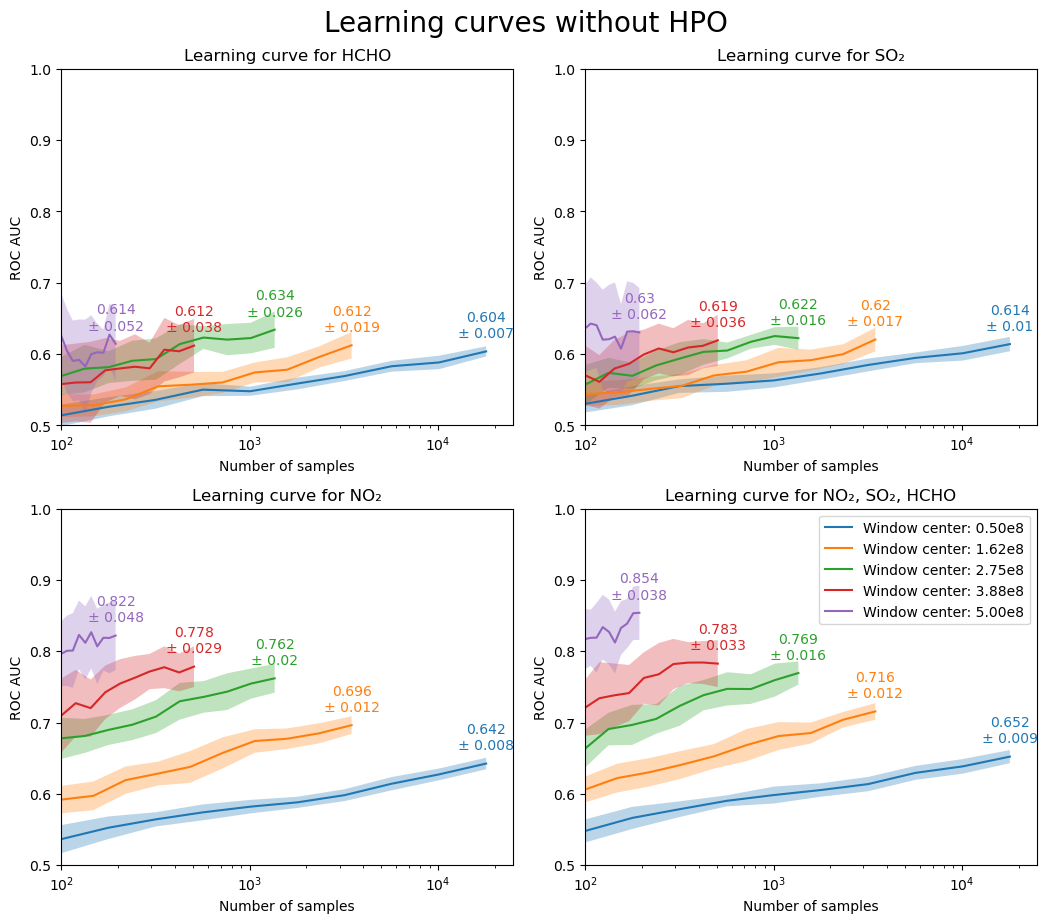

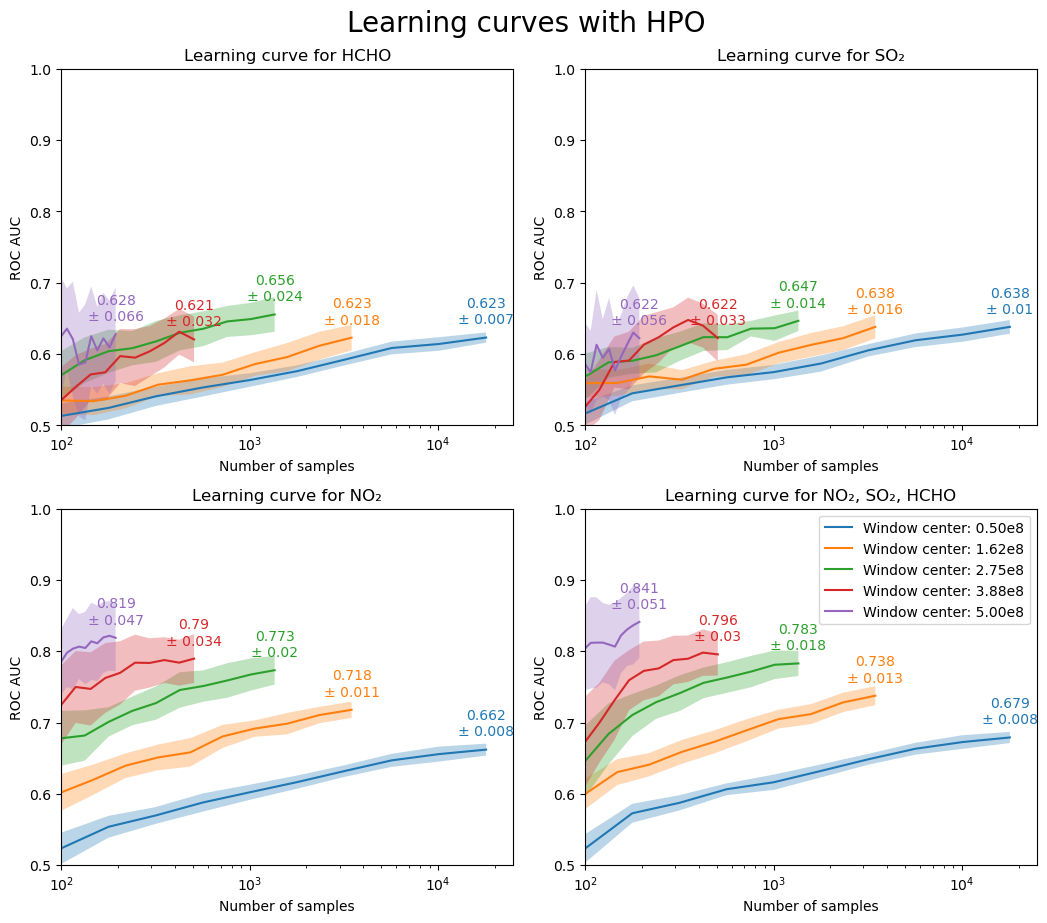

In [70]:
def plot_learning_curve(dataset_name, window_size=1e8, steps_train_size=10, folds=5, repeats=15, tuning_steps=30, hpo=True, window_centers=np.linspace(0.5e8, 5e8, 5)):
    
    directory = f"pkl/{dataset_name}/learning_curve_proxy/"
    combinations = [['HCHO'], ['SO2'], ['NO2'], ['NO2', 'SO2', 'HCHO']]

    metrics = ['roc_auc', 'avg_prec']
    metrics = ['roc_auc']

    # Create a figure to hold both metrics
    fig, ax = _initialize_figure(len(combinations), metrics)

    # Loop over both metrics and each combination
    # for metric_index, metric in enumerate(metrics):
    metric = 'roc_auc'
    for i, combination in enumerate(combinations):
        for window in window_centers:
            try:
                train_sizes_abs, scores = _load_scores(dataset_name, directory, combination, window, metric, repeats, folds, steps_train_size, tuning_steps, hpo)
                _plot_learning_curve(ax[i], train_sizes_abs, scores, window, combination, metric)
            except FileNotFoundError as e:
                logging.warning(str(e))

    _finalize_plot(fig, ax, dataset_name, hpo, len(window_centers))


def _initialize_figure(num_combinations, metrics, scale=1.25):
    fig, ax = plt.subplots(2, 2, figsize=(8.5*scale,7.5*scale))
    if num_combinations == 1:
        ax = np.expand_dims(ax, axis=0)
    # flatten the axes array
    ax = ax.flatten()
    return fig, ax


def _load_scores(dataset_name, directory, combination, window, metric, repeats, folds, steps_train_size, tuning_steps, hpo):
    parameters = {
        "combination": '_'.join(combination),
        "window_center": f"{window/1e8:.1f}e8",
        "repeats": repeats,
        "folds": folds,
        "steps_train_size": steps_train_size,
        "tuning_steps": tuning_steps,
        "hpo": hpo
    }
    filename = learn_tools.generate_filename("learning_curve", parameters, directory=directory)

    if not os.path.exists(filename):
        raise FileNotFoundError(f"Data not found for {learn_tools.gasses_to_string('_'.join(combination))} with window center {window/1e8:.1f}e8")

    with open(filename, "rb") as f:
        train_sizes_abs, roc_auc_scores, avg_prec_scores = pickle.load(f)

    if metric == 'roc_auc':
        scores = roc_auc_scores
    elif metric == 'avg_prec':
        scores = avg_prec_scores
    else:
        raise ValueError(f"Unknown metric: {metric}")

    return train_sizes_abs, scores


def _plot_learning_curve(ax, train_sizes_abs, scores, window, combination, metric):
    margin_of_error = learn_tools.get_margin_of_error(scores, axis=1)
    mean_values = np.nanmean(scores, axis=1)
    ax.plot(train_sizes_abs, mean_values, label=f"Window center: {window/1e8:.2f}e8")
    round_mean = np.round(mean_values[-1], decimals=3)
    # std_dev = np.nanstd(scores, axis=1)
    round_ci = np.round(margin_of_error[-1], decimals=3)
    ax.annotate(f"{round_mean}\n± {round_ci}", (train_sizes_abs[-1], mean_values[-1]),
                textcoords="offset points", xytext=(0, 10), ha='center',
                c=ax.get_lines()[-1].get_color())

    ax.fill_between(train_sizes_abs, mean_values - margin_of_error, mean_values + margin_of_error, alpha=0.3)

    ax.set_ylim(0.5, 1)
    ax.set_xlim(100, 2.5e4)
    ax.set_xscale('log')
    ax.set_xlabel('Number of samples')
    formatted_metric_name = metric.upper().replace("_", " ")
    ax.set_ylabel(formatted_metric_name)
    ax.set_title(f"Learning curve for {learn_tools.gasses_to_string('_'.join(combination))}")


def _finalize_plot(fig, ax, dataset_name, hpo, num_window_centers):
    plt.suptitle(f"Learning curves with{'out' if not hpo else ''} HPO", fontsize=20)
    # handles, labels = ax[0, 0].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper center', ncol=num_window_centers)
    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.legend()
    plt.tight_layout()

    output_dir = f"../../Figures/{dataset_name}/roc_auc_curves/"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f"{output_dir}proxy_trunc_hpo-{hpo}.pdf")
    plt.show()


# Example usage:
plot_learning_curve(DATASET_NAME, hpo=False, **KWARGS_TRUNC_CURVE)
plot_learning_curve(DATASET_NAME, hpo=True, **KWARGS_TRUNC_CURVE)


# 3D Heatmap

X-axis: number of samples
Y-axis: Proxhy threshold
Z-axis: Test ROC AUC

In [100]:
class Heatmap:
    def __init__(
        self, 
        data: pd.DataFrame,
        combinations: list,
        nsteps: int = 20, 
        repeats: int = 10, 
        threshold_method: str = "floor", 
        yspace: str = "linspace", 
        xspace: str = "logspace",
        window_size: float = None,
        vmin: float = 0.5,
        vmax: float = 0.85,
        base_seed: int = 42,
        n_fold: int = 5

    ):
        """
        Initialize the Heatmap object with the given parameters.
        
        Parameters:
        - data (pd.DataFrame): The input dataframe.
        - nsteps (int): The number of steps to generate the thresholds.
        - repeats (int): The number of repeats for cross-validation.
        - threshold_method (str): The method to use for thresholding. "floor" or "bins".
        - yspace (str): The space in which to generate the thresholds. "linspace", "logspace", or "quantile".
        - xspace (str): The space in which to generate the number of training samples. "linspace" or "logspace".
        - window_size (float, optional): The width of the sliding window for "bins" method. Required if `threshold_method` is "bins".
        """
        self.data = data
        self.nsteps = nsteps
        self.repeats = repeats
        self.threshold_method = threshold_method
        self.yspace = yspace
        self.xspace = xspace
        self.window_size = window_size
        self.vmin = vmin
        self.vmax = vmax
        self.nfold = n_fold
        self.base_seed = base_seed
        self.hparams = {'subsample': 0.8999999999999999, 'reg_alpha': 0.01, 'n_estimators': 150, 'min_child_weight': 8, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.05}

        if self.threshold_method == "bins" and self.window_size is None:
            raise ValueError("`window_size` must be provided when `threshold_method` is 'bins'.")


        self.gases = ['NO2', 'HCHO', 'SO2']
        self.combinations = combinations
        print(self.combinations)

    def generate_combinations(self):
        """Generate gas combinations for analysis."""
        combinations = []
        for i in range(1, len(self.gases) + 1):
            c = itertools.combinations(self.gases, i)
            for com in c:
                combinations.append(com)
        return combinations

    def calculate_learning_curve(self, combination, random_state=None):
        """Calculate learning curve for the given dataset and return the test scores."""

        threshold_data = learn_tools.proxy_threshold(
                self.data, 
                space=self.yspace, 
                n_steps=self.nsteps, 
                threshold_method=self.threshold_method,
                window_size=self.window_size,
                seed=random_state
            )
        
        test_scores_all = np.empty((self.nfold, self.nsteps, self.nsteps))
        i=0
        loop = tqdm(threshold_data.items(), desc="Processing Thresholds", leave=False)
        for threshold, proxy_df in loop:
            features = learn_tools.get_features(combination)
            X = proxy_df[features]
            Y = proxy_df['ship_y']
            group = proxy_df['date']

            model = XGBClassifier(
                n_jobs=THREADS,
                random_state=i,
                **self.hparams
                )
            cv = StratifiedGroupKFold(n_splits=self.nfold, shuffle=True, random_state=i)

            if not learn_tools.all_classes_present(X, Y, group, cv):
                print('Insufficient class representation in one of the folds. Skipping this repeat.')
                continue

            train_sizes_abs, _, test_scores = learning_curve(
                model, X, Y, groups=group, cv=cv, scoring='roc_auc', n_jobs=1, 
                train_sizes=self.get_train_frac(), shuffle=True, random_state=i
            )
            test_scores_all[:,i,:] = test_scores.T
            loop.set_postfix({"ROC AUC": np.mean(test_scores_all[:,i,:])})
            i+=1

        y_values = list(threshold_data.keys())

        return test_scores_all, train_sizes_abs, y_values # Average across folds

    def get_train_frac(self):
        """Get the appropriate train fraction based on the xspace."""
        if self.xspace == "logspace":
            space = np.logspace(-1, 0, self.nsteps)
            return space
        else:
            return np.linspace(0.1, 1.0, self.nsteps)

    def plot_combination(self, ax, combination, all_test_scores, extent, y_values, train_sizes_abs, levels=10):
        """Plot a heatmap for a specific gas combination using contourf."""
        ax.set_title(f"Gases: {', '.join(combination)}".replace("2", "₂"), fontsize=20)
        
        # Plot using contourf
        im = ax.imshow(
            np.mean(all_test_scores, axis=0),
            cmap='viridis',
            aspect='auto',
            extent=extent,
            origin='lower',
            vmin=self.vmin, vmax=self.vmax
        )

        # annotate the last value with mean and std, using a line that points to the point
        mean = np.mean(all_test_scores, axis=0)
        std = np.std(all_test_scores, axis=0)
        last_mean = mean[-1, -1]
        last_std = std[-1, -1]
        margin_of_error = learn_tools.get_margin_of_error(all_test_scores[:,-1,-1], axis=0)
        print(all_test_scores[:,-1,-1].shape)
        ticksize = 14
        ax.annotate(
            f"{last_mean:.3f} ± {margin_of_error:.3f}",
            (train_sizes_abs[-1], y_values[-1]),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center',
            c='black',
            fontsize=ticksize
        )

        y_values = np.array(y_values)
        train_sizes_abs = np.array(train_sizes_abs)

        # get step between values
        x_step = train_sizes_abs[1] - train_sizes_abs[0]
        y_step = y_values[1] - y_values[0]

        x_top = train_sizes_abs[-1] - x_step/2
        x_bottom = train_sizes_abs[0] + x_step/2

        y_top = y_values[-1] - y_step/2
        y_bottom = y_values[0] + y_step/2

        x_locations = np.linspace(x_bottom, x_top, len(train_sizes_abs))
        y_locations = np.linspace(y_bottom, y_top, len(y_values))

        # x_labels = [f"{x:.2e}" for x in train_sizes_abs]
        x_labels = train_sizes_abs
        y_labels = [f"{y:.2e}" for y in y_values]


        ax.set_xticks(x_locations, x_labels, fontsize=ticksize, rotation=45)
        ax.set_yticks(y_locations, y_labels, fontsize=ticksize)

        return im

    def run_combination(self, combination):
        gasses = list(combination)
        gas_key = "_".join(gasses)
        self.title = f"{DATASET_NAME}/HeatMap/yspace-{self.yspace}/xspace-{self.xspace}/threshold-{self.threshold_method}/nsteps-{self.nsteps}/window-{self.window_size/1e8}e8/"
        runs = glob.glob(f"tmp/{self.title}/{gas_key}/*.pkl")
        new_test_scores = np.zeros((self.repeats * self.nfold, self.nsteps, self.nsteps))

        if len(runs) > 0:
            runs_repeats = [int(Path(r).stem) for r in runs]
            max_repeats = max(runs_repeats)
            max_repeats_idx = runs_repeats.index(max_repeats)
            all_test_scores, train_sizes_abs, y_values = pickle.load(open(runs[max_repeats_idx], "rb"))

            if max_repeats < self.repeats:
                remaining_repeats = self.repeats - max_repeats
            else:
                return all_test_scores, train_sizes_abs, y_values
            new_test_scores[:max_repeats*self.nfold] = all_test_scores
        else:
            remaining_repeats = self.repeats
            max_repeats = 0

        for i in tqdm(range(remaining_repeats), desc="Processing Repeats", leave=False):
            test_scores, train_sizes_abs, y_values = self.calculate_learning_curve(combination, random_state=i)
            assert test_scores.shape == (self.nfold, self.nsteps, self.nsteps)
            new_test_scores[max_repeats*self.nfold+i*self.nfold:max_repeats*self.nfold+(i+1)*self.nfold] = test_scores

        os.makedirs(f"tmp/{self.title}/{gas_key}", exist_ok=True)
        with open(f"tmp/{self.title}/{gas_key}/{self.repeats}.pkl", "wb") as f:
            pickle.dump((new_test_scores, train_sizes_abs, y_values), f)

        return new_test_scores, train_sizes_abs, y_values

    def learning_heatmap(self):
        """Generate and display a heatmap of the learning curves for different gas combinations."""
        num_combinations = len(self.combinations)
        num_cols = 2
        num_rows = int(np.ceil(num_combinations / num_cols))

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(8.5 * num_cols, 9 * num_rows), constrained_layout=True)
        axes = axes.flatten()

        ax_idx = 0
        all_im = []  # To keep track of all contourf objects for colorbar
        
        for combination in tqdm(self.combinations, desc="Processing Combinations", leave=False):
            all_test_scores, train_sizes_abs, y_values = self.run_combination(combination)
            extent = [min(train_sizes_abs), max(train_sizes_abs), min(y_values), max(y_values)]
            im = self.plot_combination(axes[ax_idx], combination, all_test_scores, extent, y_values, train_sizes_abs)
            # axes[ax_idx].set_aspect('equal')  # Make the subplot square
            all_im.append(im)
            ax_idx += 1

        # Hide remaining axes
        for ax in axes[ax_idx:]:
            ax.axis('off')
        
        # Add a single x-label and y-label for the entire figure
        fig.text(0.5, 0.09, 'Number of Training Samples', ha='center', fontsize=20)
        fig.text(-0.02, 0.5, 'Proxy Window Center' if self.yspace != 'quantile' else 'Proxy Threshold Quantile', 
                 va='center', rotation='vertical', fontsize=20)

        # Assuming all contourf have the same levels
        # Use the first one for the colorbar
        cbar = fig.colorbar(all_im[0], ax=axes[:ax_idx], shrink=0.6, orientation='horizontal', ticks=np.linspace(self.vmin, self.vmax, 8))
        cbar.ax.tick_params(which='both', labelsize=15)
        cbar.set_label(label="ROC AUC", fontsize=20, labelpad=15)

        if self.threshold_method == "bins":
            fig.suptitle(f"{self.nsteps}x{self.nsteps} Heatmap with {self.yspace} space and {self.threshold_method} method,\nwindow size: {int(self.window_size/1e8)}e8, repeated {self.repeats} times", fontsize=35)
        else:
            fig.suptitle(f"Heatmap with {self.yspace} space and {self.threshold_method} method, repeated {self.repeats} times", fontsize=35)

        
        os.makedirs(f"../../Figures/{self.title}", exist_ok=True)
        plt.savefig(f"../../Figures/{self.title}/{self.repeats}_{self.combinations}.pdf", bbox_inches='tight')
        plt.show()

[('NO2',), ('HCHO',), ('SO2',)]


Processing Combinations:   0%|          | 0/3 [00:00<?, ?it/s]

(50,)
(50,)


(50,)


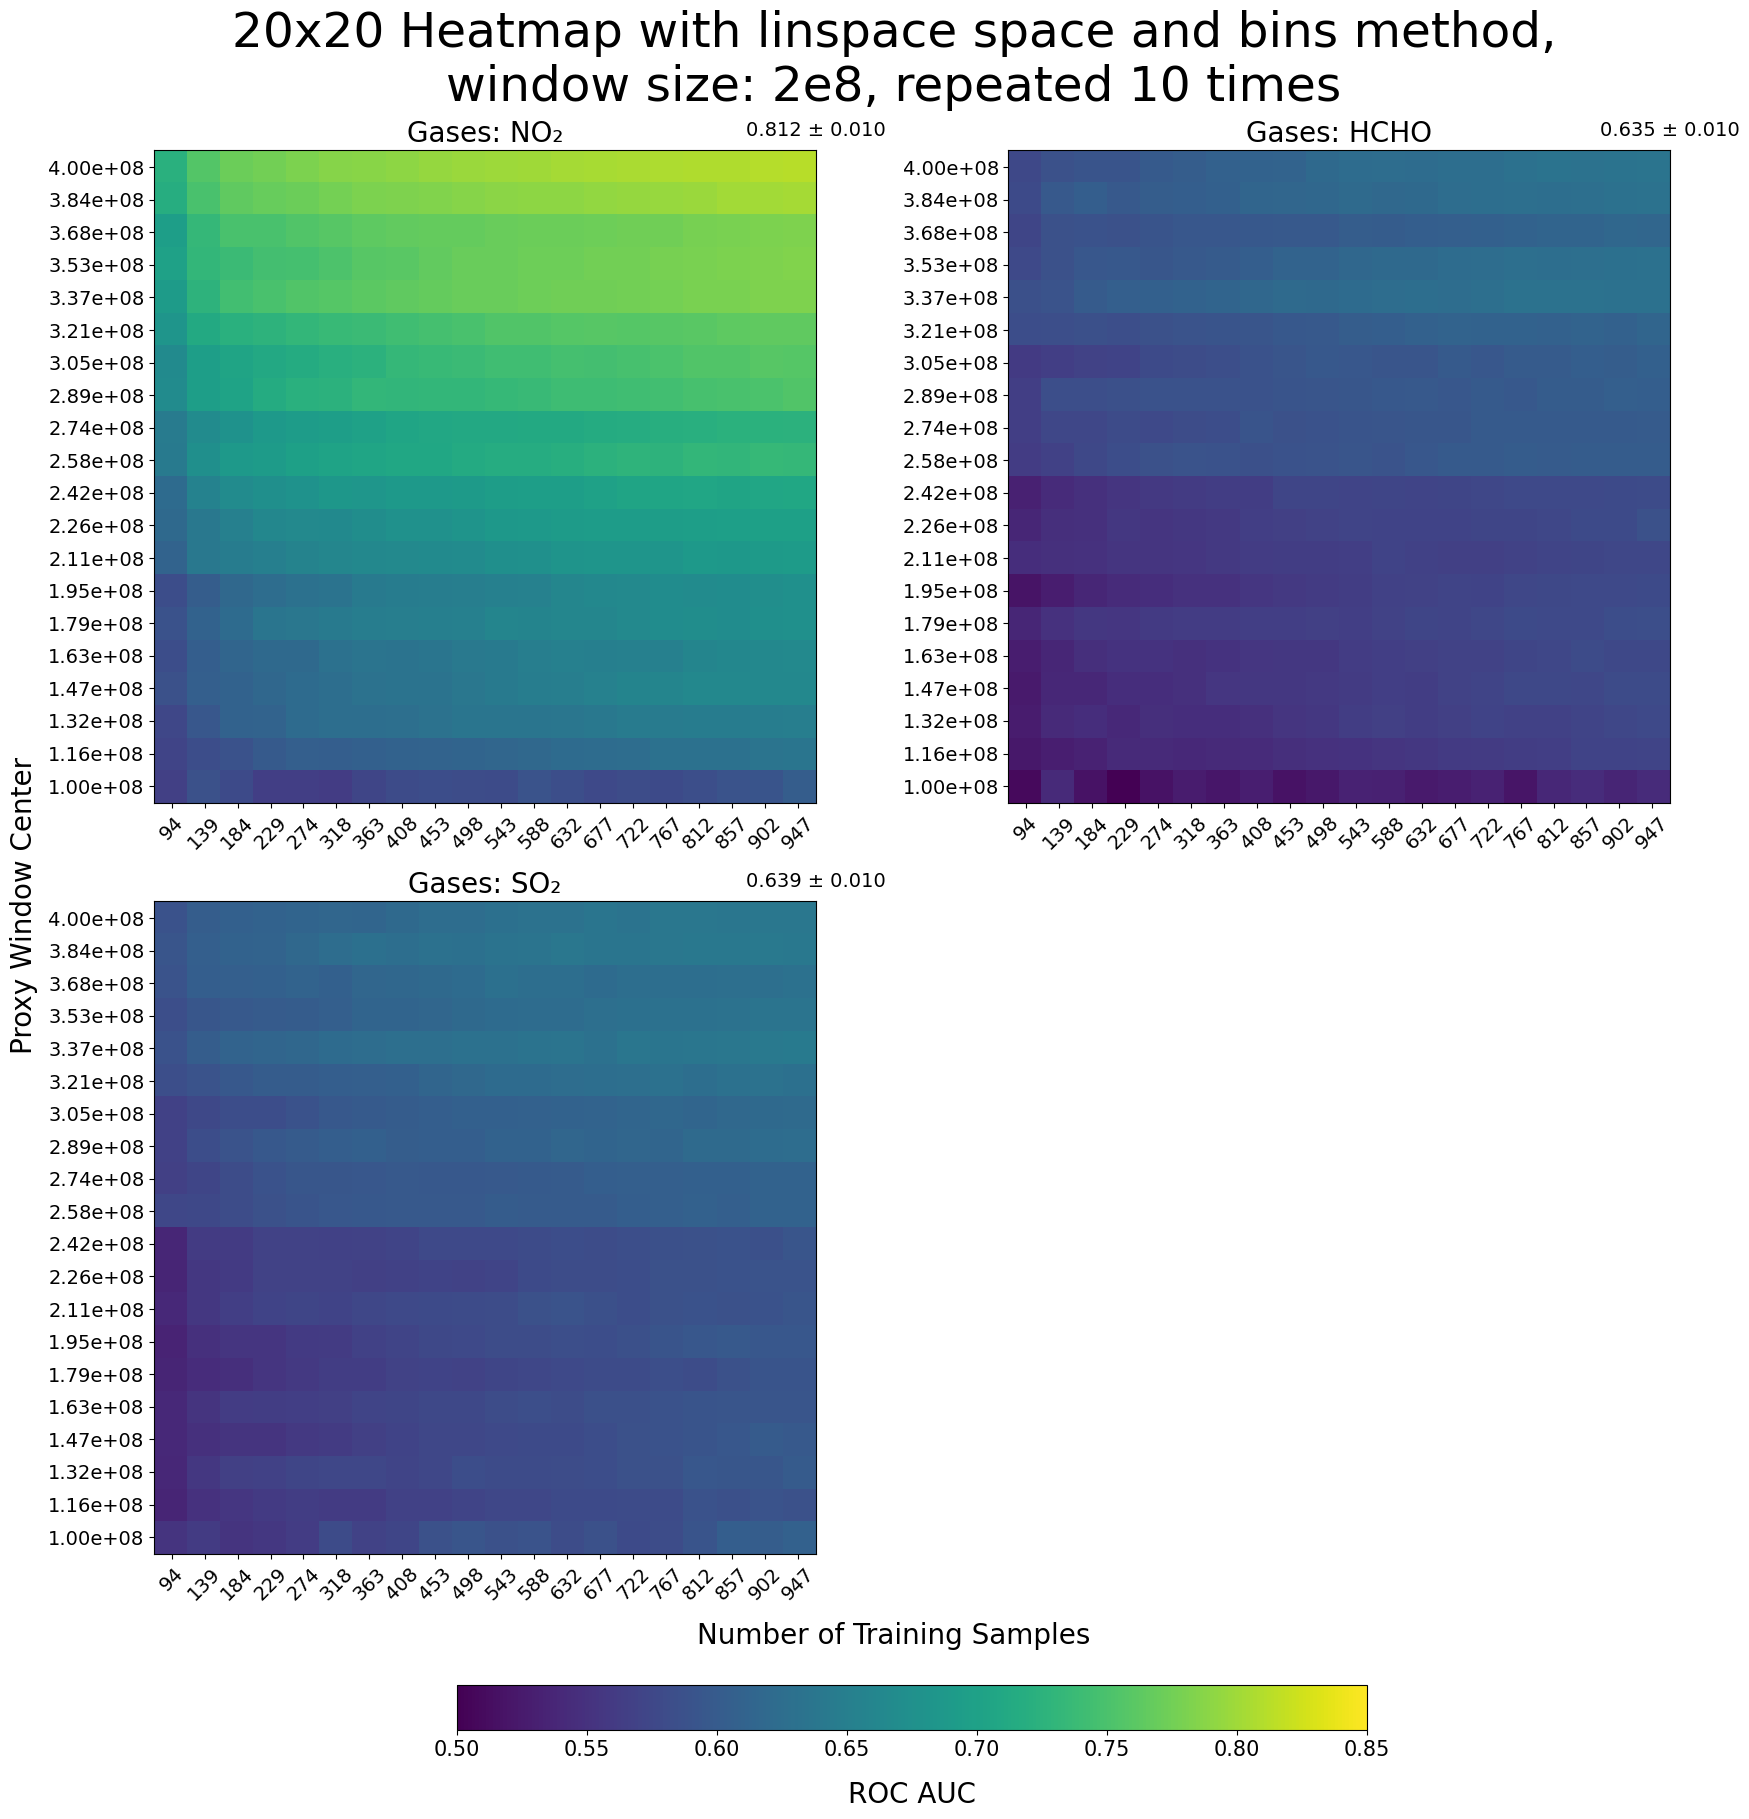

[('NO2', 'HCHO'), ('NO2', 'SO2'), ('HCHO', 'SO2'), ('NO2', 'HCHO', 'SO2')]


(50,)
(50,)
(50,)
(50,)


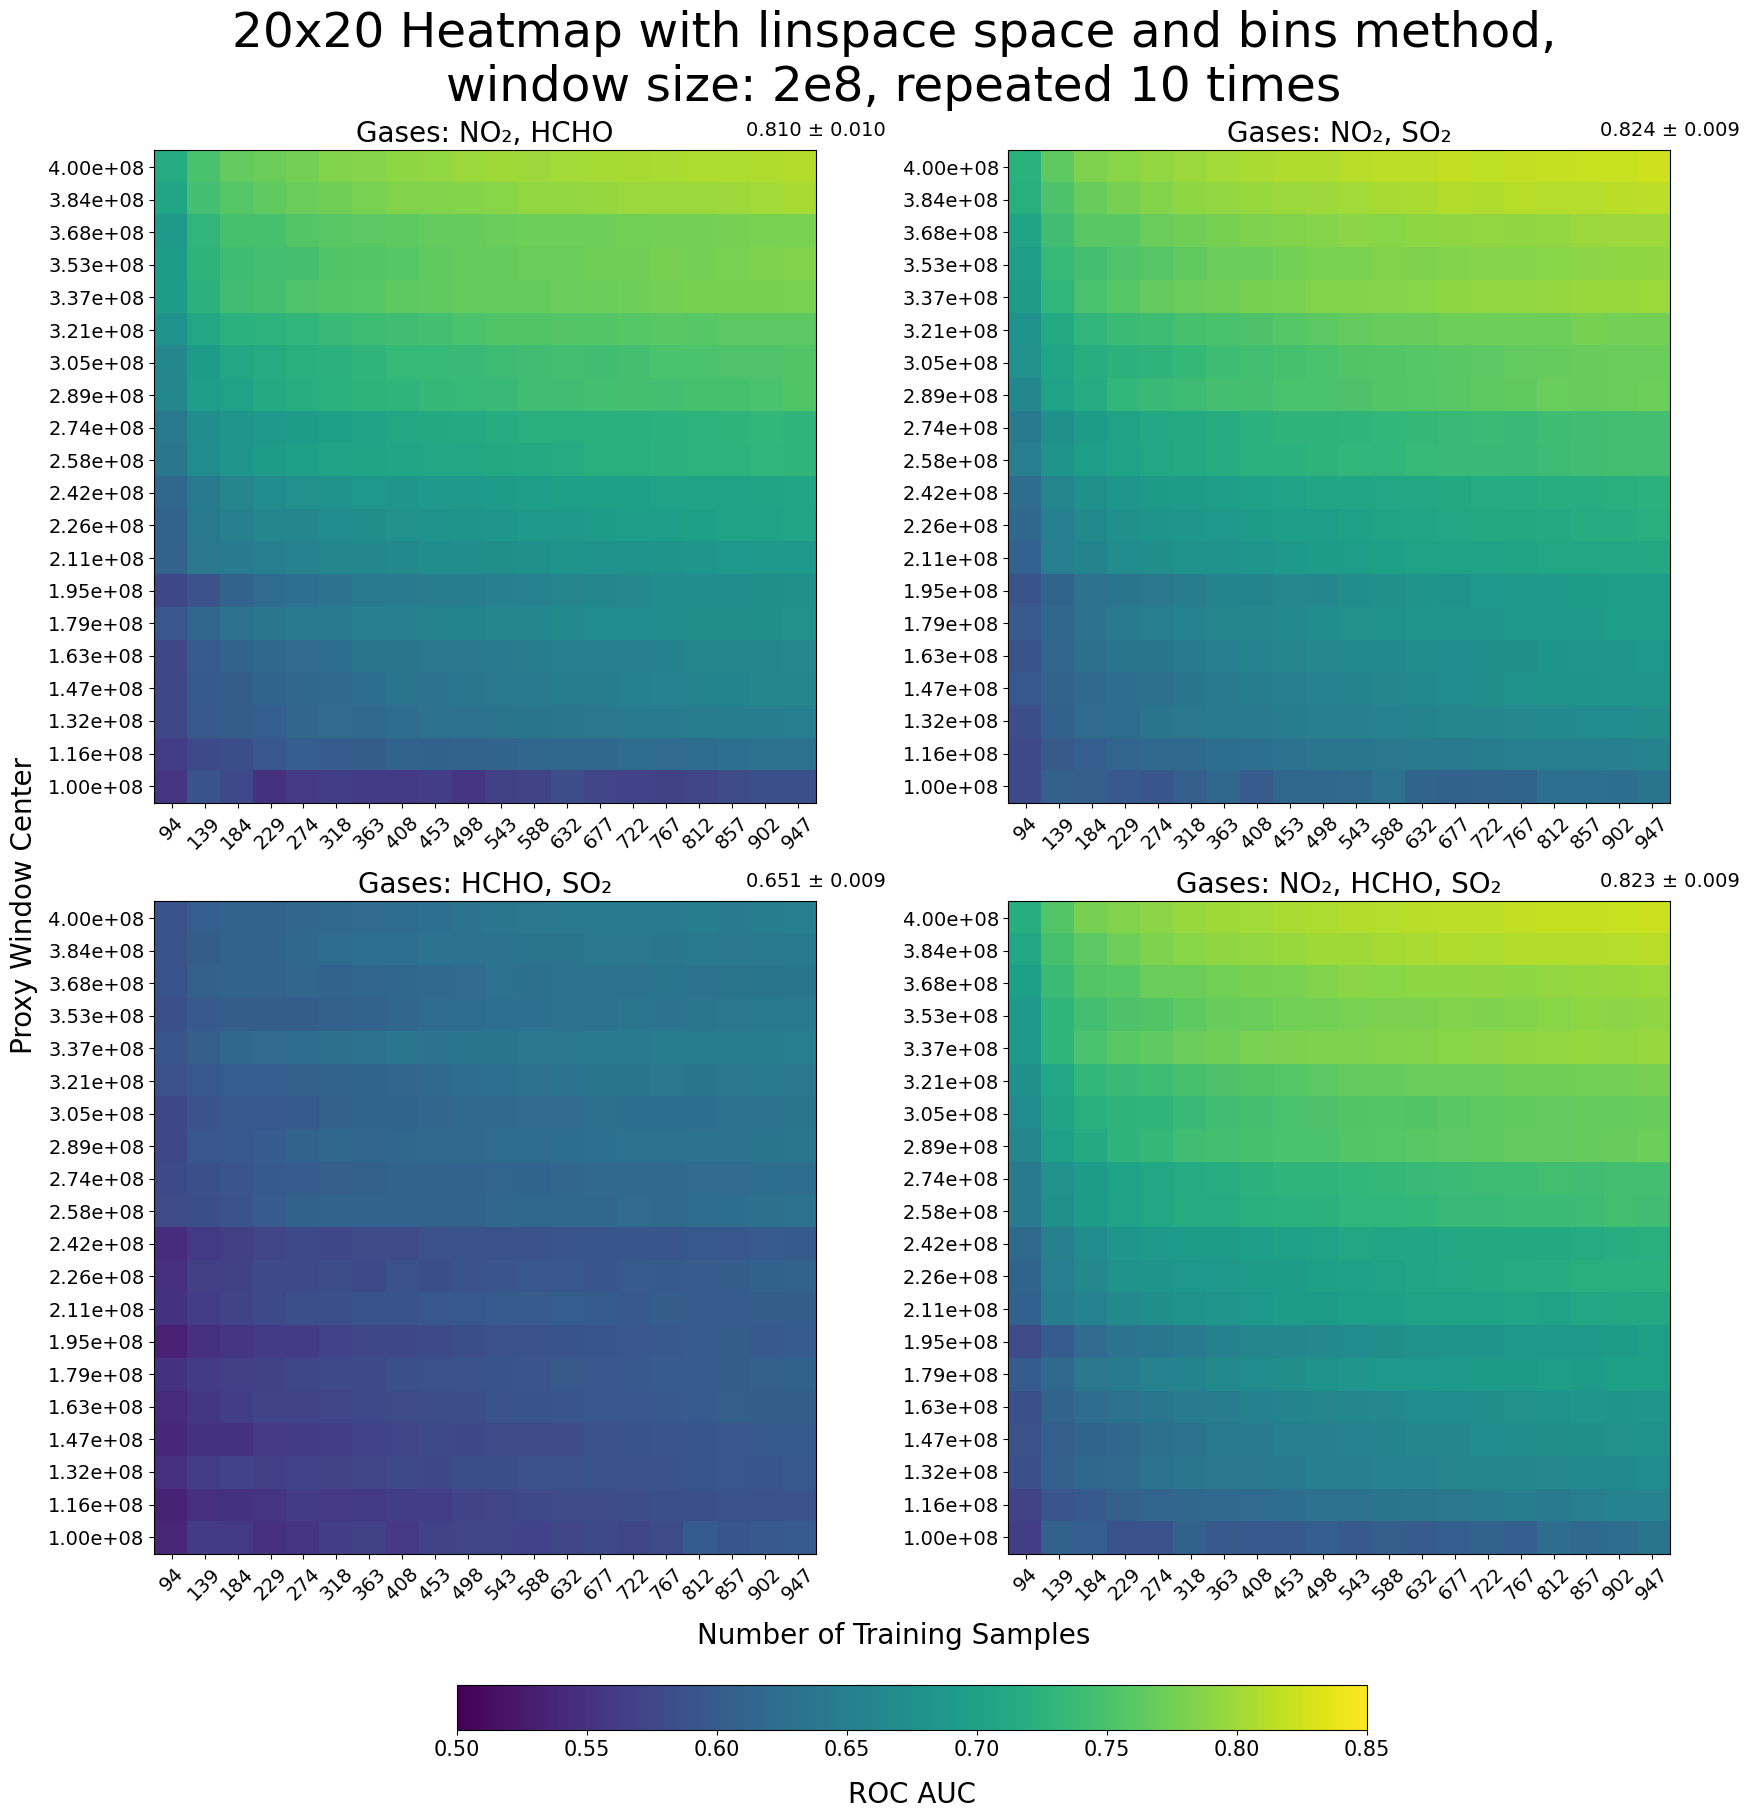

In [101]:
# Example usage with sliding window binning
heatmap_sliding = Heatmap(
    data=DF_MED,
    yspace="linspace", 
    threshold_method="bins", 
    xspace="linspace", 
    nsteps=20,          # Number of sliding windows
    repeats=10,
    combinations = [('NO2',), ('HCHO',), ('SO2',)],
    window_size=2*10**8     # Adjust window size as needed
)
heatmap_sliding.learning_heatmap()

# Example usage with sliding window binning
heatmap_sliding = Heatmap(
    data=DF_MED,
    yspace="linspace", 
    threshold_method="bins", 
    xspace="linspace", 
    nsteps=20,          # Number of sliding windows
    repeats=10,
    combinations = [('NO2', 'HCHO'), ('NO2', 'SO2'), ('HCHO', 'SO2'), ('NO2', 'HCHO', 'SO2')],
    window_size=2*10**8     # Adjust window size as needed
)
heatmap_sliding.learning_heatmap()


# Proxy bin vs Performance

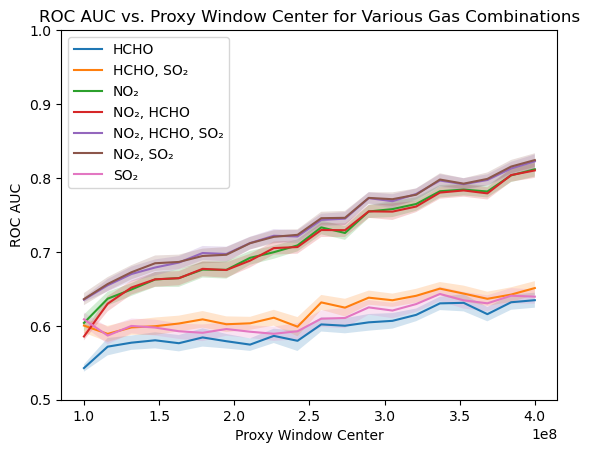

In [73]:
# Code\ML\tmp\3\HeatMap\yspace-linspace\xspace-linspace\threshold-bins\nsteps-20\window-2.0e8\HCHO\10.pkl
# Step 1: load the data ran in the previous step
# plt.figure(figsize=(10, 6))
files = glob.glob(f"tmp/{DATASET_NAME}/HeatMap/yspace-linspace/xspace-linspace/threshold-bins/nsteps-20/window-2.0e8/*/10.pkl")
for file in files:
    all_test_scores, train_sizes_abs, y_values = pickle.load(open(file, "rb"))
    # select last column
    last_column = all_test_scores[:, :, -1]
    combination = Path(file).parent.stem
    combination = learn_tools.gasses_to_string(combination)

    mean_test_scores = np.mean(last_column, axis=0)

    plt.plot(y_values, mean_test_scores, label=combination)

    # plot confidence interval
    margin_of_error = learn_tools.get_margin_of_error(last_column, axis=0)

    plt.fill_between(y_values, mean_test_scores - margin_of_error, mean_test_scores + margin_of_error, alpha=0.2)
plt.xlabel('Proxy Window Center')
plt.ylabel('ROC AUC')
plt.title('ROC AUC vs. Proxy Window Center for Various Gas Combinations')
plt.ylim(0.5, 1)
plt.legend()
os.makedirs(f"../../Figures/{DATASET_NAME}/roc_auc_curves/", exist_ok=True)
plt.savefig(f"../../Figures/{DATASET_NAME}/roc_auc_curves/proxy_window_center.pdf")
plt.show()

# Learning curve all data

In [74]:
import learn_tools

class LearningCurveAll:
    def __init__(
            self, 
            dataset_name, 
            # Parameters for the learning curve
            steps_train_size, 
            folds, 
            repeats, 
            tuning_steps, 
            
            hpo=True, 
            overwrite=False,

                 ):
        self.dataset_name = dataset_name
        self.steps_train_size = steps_train_size
        self.folds = folds
        self.repeats = repeats
        self.tuning_steps = tuning_steps
        self.hpo = hpo
        self.directory = f"pkl/{self.dataset_name}/learning_curve_all/"

        gases = ['NO2', 'HCHO', 'SO2']    
        combinations = [list(com) for i in range(1, len(gases) + 1) for com in itertools.combinations(gases, i)]
        self.combinations = combinations
        
        self.overwrite = overwrite
        logging.info(f"Initialized LearningCurveAnalysis with HPO: {self.hpo}")

    def run(self):
        for combination in tqdm(self.combinations):
            # Generate the filename based on the current parameters
            parameters = {
                "combination": '_'.join(combination),
                "repeats": self.repeats,
                "folds": self.folds,
                "steps_train_size": self.steps_train_size,
                "tuning_steps": self.tuning_steps,
                "hpo": self.hpo
            }
            filename = learn_tools.generate_filename("learning_curve", parameters, directory=self.directory)

            if os.path.exists(filename) and not self.overwrite:
                print(f"Results for {combination} already exist. Skipping.")
                continue

            datasets, train_indices, test_indices = self.create_splits()
            train_sizes_abs = self.get_train_sizes(train_indices)

            roc_auc_scores, avg_prec_scores = self.train_and_evaluate(
                datasets, train_indices, test_indices, train_sizes_abs, combination
            )

            # Save results
            self.save_results(filename, train_sizes_abs, roc_auc_scores, avg_prec_scores)

    def get_data_for_window(self, seed):
        """
        Retrieves and prepares data for the given window.
        """
        one_data = DF_MED[DF_MED['ship_y'] == 1]
        zero_data = DF_MED[DF_MED['ship_y'] == 0]
        # balance the data
        if len(one_data) > len(zero_data):
            one_data = one_data.sample(n=len(zero_data), random_state=seed, replace=False)
        else:
            zero_data = zero_data.sample(n=len(one_data), random_state=seed, replace=False)
        return one_data, zero_data

    def create_splits(self):
        """
        Create training and testing splits.
        """
        datasets, train_indices, test_indices = [], [], []
        for i in range(self.repeats):
            one_data, zero_data = self.get_data_for_window(i)
            data = pd.concat([one_data, zero_data])
            # shuffle data
            data = data.sample(frac=1, random_state=i).reset_index(drop=True)
            splitter = GroupShuffleSplit(n_splits=1, train_size=0.9, random_state=i)
            train_index, test_index = next(splitter.split(data, groups=data['date']))
            datasets.append(data)
            train_indices.append(train_index)
            test_indices.append(test_index)
        return datasets, train_indices, test_indices

    def get_train_sizes(self, train_indices):
        """
        Determines the training sizes to be used in the learning curve.
        """
        train_sizes_max = min(len(train_index) for train_index in train_indices)
        train_sizes_min = 100
        assert train_sizes_max > train_sizes_min
        return np.geomspace(train_sizes_min, train_sizes_max, self.steps_train_size, dtype=int)

    def train_and_evaluate(self, datasets, train_indices, test_indices, train_sizes_abs, combination):
        """
        Trains the model and evaluates its performance for different training sizes.
        """
        roc_auc_scores = np.empty((self.steps_train_size, self.repeats))
        avg_prec_scores = np.empty((self.steps_train_size, self.repeats))

        repeat_loop = tqdm(zip(datasets, train_indices, test_indices), leave=False, desc="Repeats", total=self.repeats)
        for i, (data, train_index, test_index) in enumerate(repeat_loop):
            # Prepare features and target
            features = learn_tools.get_features(combination)
            X = data[features]
            target = 'ship_y'
            Y = data[target]
            group = data['date']

            model_learning_curve = self.prepare_model(X, Y, train_index, group, i)

            # Train the model on different train sizes
            rng = np.random.RandomState(i)
            train_index = rng.permutation(train_index)
            for train_size_index, train_size in enumerate(train_sizes_abs):
                train_index_curve = train_index[:train_size]
                X_train_curve = X.iloc[train_index_curve]
                Y_train_curve = Y.iloc[train_index_curve]

                model_learning_curve.fit(X_train_curve, Y_train_curve)

                # Evaluate performance
                test_probs = model_learning_curve.predict_proba(X.iloc[test_index])[:, 1]
                roc_auc_scores[train_size_index, i] = roc_auc_score(Y.iloc[test_index], test_probs)
                avg_prec_scores[train_size_index, i] = average_precision_score(Y.iloc[test_index], test_probs)

        return roc_auc_scores, avg_prec_scores

    def prepare_model(self, X, Y, train_index, group, seed):
        """
        Prepares and returns a model, optionally using hyperparameter optimization.
        """
        if self.hpo:
            XGB = XGBClassifier(random_state=seed)
            inner_cv = StratifiedGroupKFold(n_splits=self.folds, random_state=seed, shuffle=True)
            model_tuner = BayesSearchCV(
                estimator=XGB,
                search_spaces=SEARCH_SPACE,
                scoring='roc_auc',
                cv=inner_cv,
                n_jobs=1, # use single thread to avoid thread thrashing
                refit=False,
                verbose=0,
                n_iter=self.tuning_steps,
                random_state=seed
            )
            model_tuner.fit(X.iloc[train_index], Y.iloc[train_index], groups=group.iloc[train_index])
            best_params = model_tuner.best_params_
            return XGBClassifier(random_state=seed, **best_params)
        else:
            return XGBClassifier(random_state=seed)

    def save_results(self, filename, train_sizes_abs, roc_auc_scores, avg_prec_scores):
        """
        Saves results to a specified directory.
        """
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        with open(filename, "wb") as f:
            pickle.dump((train_sizes_abs, roc_auc_scores, avg_prec_scores), f)


In [75]:
KWARGS_ALL_CURVE = {
    'steps_train_size': 30, 
    'folds': 5, 
    'repeats': 15, 
    'tuning_steps': 30, 
    }

learning_curve_all = LearningCurveAll(dataset_name=DATASET_NAME, **KWARGS_ALL_CURVE, hpo=False)
learning_curve_all.run()

learning_curve_all = LearningCurveAll(dataset_name=DATASET_NAME, **KWARGS_ALL_CURVE, hpo=True)
learning_curve_all.run()

winsound.Beep(440, 1000)

  0%|          | 0/7 [00:00<?, ?it/s]

Results for ['NO2'] already exist. Skipping.
Results for ['HCHO'] already exist. Skipping.
Results for ['SO2'] already exist. Skipping.
Results for ['NO2', 'HCHO'] already exist. Skipping.
Results for ['NO2', 'SO2'] already exist. Skipping.
Results for ['HCHO', 'SO2'] already exist. Skipping.
Results for ['NO2', 'HCHO', 'SO2'] already exist. Skipping.


  0%|          | 0/7 [00:00<?, ?it/s]

Results for ['NO2'] already exist. Skipping.
Results for ['HCHO'] already exist. Skipping.
Results for ['SO2'] already exist. Skipping.
Results for ['NO2', 'HCHO'] already exist. Skipping.
Results for ['NO2', 'SO2'] already exist. Skipping.
Results for ['HCHO', 'SO2'] already exist. Skipping.
Results for ['NO2', 'HCHO', 'SO2'] already exist. Skipping.


0.6606617228221119
0.6125775200724151
0.6261236629796957
0.6636815585341471
0.6739503556208795
0.6297295885144057
0.6765159514729949


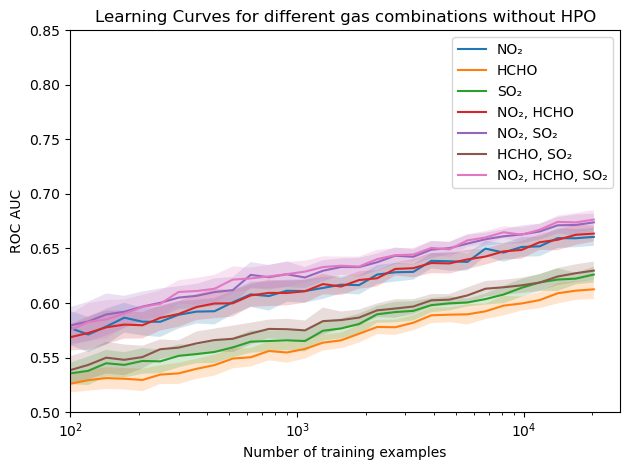

0.684472500374211
0.6336960769192406
0.6474393931739011
0.6894342791076689
0.7004016970613056
0.655000997543429
0.7040144063816686


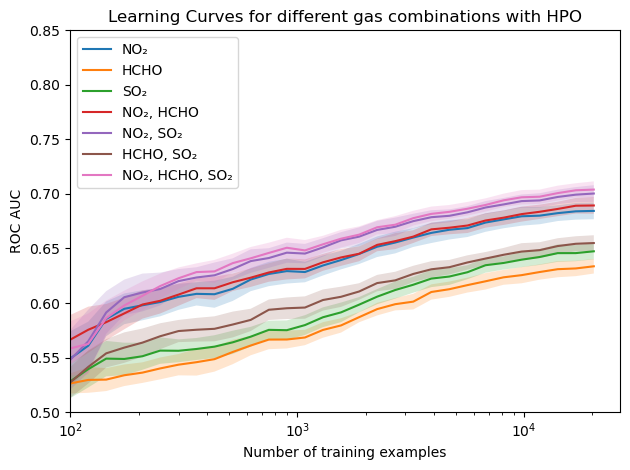

In [76]:
import pandas as pd
import numpy as np
import itertools
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming learn_tools is a module containing helper functions such as generate_filename and get_margin_of_error


def plot_combined_learning_curves_with_summary(steps_train_size, folds, repeats, tuning_steps, hpo):
    # Two subplots, one for each metric

    # Define the list of gases
    gases = ['NO2', 'HCHO', 'SO2']
    metrics = ['ROC AUC', 'AVG PREC']
    metrics = ['ROC AUC']
    scoring = 'roc_auc'
    # fig = plt.figure(figsize=(15, 10))
    
    # Generate all possible combinations of gases
    combinations = [list(com) for i in range(1, len(gases) + 1) for com in itertools.combinations(gases, i)]
    directory = f"pkl/{DATASET_NAME}/learning_curve_all/"

    # DataFrame to store the final values for each run
    summary_data = []

    # Iterate through each gas and its combinations
    for i, combination in enumerate(tqdm(combinations, leave=False, desc="Processing Combinations")):
        parameters = {
            "combination": '_'.join(combination),
            "repeats": repeats,
            "folds": folds,
            "steps_train_size": steps_train_size,
            "tuning_steps": tuning_steps,
            "hpo": hpo
        }
        filename = learn_tools.generate_filename("learning_curve", parameters, directory=directory)

        # Load the results
        train_sizes_abs, roc_auc_scores, avg_prec_scores = pickle.load(open(filename, "rb"))
        name = ", ".join(list(combination))

        # Iterate through each scoring metric
        scores = roc_auc_scores

        mean_scores = scores.mean(axis=1)
        margin_of_error = learn_tools.get_margin_of_error(scores, axis=1)

        # Plotting
        plt.plot(train_sizes_abs, mean_scores, label=name.replace('2', '₂'))
        plt.fill_between(train_sizes_abs, mean_scores - margin_of_error,
                            mean_scores + margin_of_error, alpha=0.2)
        plt.ylabel('ROC AUC')
        plt.xlabel('Number of training examples')
        plt.xscale('log')
        plt.ylim(0.5, 0.85)
        plt.xlim(100)

        # Collect the final values for the summary table
        final_mean = mean_scores[-1]
        final_std = scores.std(axis=1)[-1]
        final_ci95 = learn_tools.get_margin_of_error(scores[:,-1], axis=0)
        print(final_mean)
        summary_data.append({
            'Combination': name,
            'HPO': 'Yes' if hpo else 'No',
            'Metric': scoring,
            'Final Score': f"{final_mean:.3f} ± {final_ci95:.3f}"
        })    

    # Plot title and layout
    if hpo:
        title = "Learning Curves for different gas combinations with HPO"
    else:
        title = "Learning Curves for different gas combinations without HPO"
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    os.makedirs(f"../../Figures/{DATASET_NAME}/learning_curve_all/", exist_ok=True)
    plt.savefig(f"../../Figures/{DATASET_NAME}/learning_curve_all/hpo_{hpo}.pdf")
    plt.show()

    # Create a DataFrame to present the final values
    summary_df = pd.DataFrame(summary_data)

    # Save the summary table to a CSV file
    summary_filename = f"../../Figures/{DATASET_NAME}/learning_curve_all/summary_hpo_{hpo}.csv"
    summary_df.to_csv(summary_filename, index=False)

# Run the function for both cases (with and without HPO)
plot_combined_learning_curves_with_summary(**KWARGS_ALL_CURVE, hpo=False)
plot_combined_learning_curves_with_summary(**KWARGS_ALL_CURVE, hpo=True)

# Table of last values of learning curve

In [77]:
def create_combined_latex_table(dataset_name):
    # Load both CSV files
    summary_hpo_false = pd.read_csv(f"../../Figures/{dataset_name}/learning_curve_all/summary_hpo_False.csv")
    summary_hpo_true = pd.read_csv(f"../../Figures/{dataset_name}/learning_curve_all/summary_hpo_True.csv")

    # Combine both DataFrames into one
    combined_df = pd.concat([summary_hpo_false, summary_hpo_true], ignore_index=True)

    # Pivot to create a MultiIndex table
    pivot_df = combined_df.pivot(index='Combination', columns=['Metric', 'HPO'], values='Final Score')

    # Sort the columns for better readability
    # pivot_df = pivot_df.reorder_levels([1, 0], axis=1).sort_index(axis=1)
    
    # Sort columns in order of number of gases
    # pivot_df = pivot_df.reindex(sorted(pivot_df.columns, key=lambda x: x[0].count(',')))
    

    display(pivot_df)

    # Create a LaTeX table from the pivot DataFrame
    latex_table = pivot_df.to_latex(multicolumn=True, multirow=True, float_format="%.3f")
    latex_filename = f"../../Figures/{dataset_name}/learning_curve_all/summary_combined.tex"
    with open(latex_filename, "w") as f:
        f.write(latex_table)

# Create the combined LaTeX table
create_combined_latex_table(DATASET_NAME)



Metric                roc_auc               
HPO                        No            Yes
Combination                                 
HCHO            0.613 ± 0.011  0.634 ± 0.015
HCHO, SO2       0.630 ± 0.012  0.655 ± 0.017
NO2             0.661 ± 0.009  0.684 ± 0.011
NO2, HCHO       0.664 ± 0.011  0.689 ± 0.014
NO2, HCHO, SO2  0.677 ± 0.011  0.704 ± 0.013
NO2, SO2        0.674 ± 0.011  0.700 ± 0.012
SO2             0.626 ± 0.013  0.647 ± 0.015